In [3]:
import re
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from collections import Counter

home = os.path.expanduser("~")
data_dir = os.path.join(home, 'Documents/semantic-robot/testing/results')

### Extract necessary data

In [4]:
def extract_data(filename):
    with open(filename) as f:
        content = f.read()

    test_sets = re.findall(r'Test set #\s+:\s+(.+)', content)
    number_of_examples = re.findall(r'Number of examples\s+:\s+(.+)', content)
    inference_times = re.findall(r'Inference time \[s\]\s+:\s+(.+)', content)
    memory_usage = re.findall(r'GPU memory loaded \[MB\]\s+:\s+(.+)', content)
    input_size = re.findall(r'Model input size \[MB\]\s+:\s+(.+)', content)
    model = re.findall(r'Model\s+:\s+(.+)', content)
    sliced_output = re.findall(r'Sliced output\s+:\s+(.+)', content)
    solution = re.findall(r'Solution\s+:\s+(.+)', content)
    labeled = re.findall(r'Labeled\s+:\s+(.+)', content)

    return {
        'model': list(map(str, model)),
        'test_set': list(map(int, test_sets)),
        'num_examples': list(map(int, number_of_examples)),
        'sliced_output': list(map(str, sliced_output)),
        'solution': list(map(str, solution)),
        'inference_time': list(map(float, inference_times)),
        'memory_usage': list(map(float, memory_usage)),
        'input_size': list(map(float, input_size)),
        'labeled': list(map(str, labeled))
    }

In [5]:
num = 'final_'

data_4bit_unlabeled = extract_data(os.path.join(data_dir, num + 'mistral_results_4bit.txt'))
data_4bit_labeled = extract_data(os.path.join(data_dir, num + 'mistral_results_4bit_labeled.txt'))

df_4bit_unlabeled = pd.DataFrame(data_4bit_unlabeled)
df_4bit_labeled = pd.DataFrame(data_4bit_labeled)

In [6]:
inf_times_unlabeled = np.zeros(max(df_4bit_unlabeled['num_examples']))
mem_usages_unlabeled = np.zeros(max(df_4bit_unlabeled['num_examples']))
input_sizes_unlabeled = np.zeros(max(df_4bit_unlabeled['num_examples']))

sliced_outputs_unlabeled = []

for i in range(2, max(df_4bit_unlabeled['num_examples'])+1):
    idxs = df_4bit_unlabeled.loc[df_4bit_unlabeled['num_examples'] == i]
    
    inference_times_unlabeled = [float(x) for x in idxs['inference_time']]
    if inference_times_unlabeled:
        avg_inference_time_unlabeled = sum(inference_times_unlabeled) / len(inference_times_unlabeled)
    else:
        avg_inference_time_unlabeled = 0

    memory_usage_unlabeled = [float(x) for x in idxs['memory_usage']]
    if memory_usage_unlabeled:    
        avg_memory_usage_unlabeled = sum(memory_usage_unlabeled) / len(memory_usage_unlabeled)
    else:
        avg_memory_usage_unlabeled = 0

    input_size_unlabeled = [float(x) for x in idxs['input_size']]
    if input_size_unlabeled:    
        avg_input_size_unlabeled = sum(input_size_unlabeled) / len(input_size_unlabeled)
    else:
        avg_input_size_unlabeled = 0
    
    sliced_output_unlabeled = [str(x) for x in idxs['sliced_output']]
    sliced_outputs_unlabeled.append(sliced_output_unlabeled)

    inf_times_unlabeled[i-2] = avg_inference_time_unlabeled
    mem_usages_unlabeled[i-2] = avg_memory_usage_unlabeled
    input_sizes_unlabeled[i-2] = avg_input_size_unlabeled

sliced_outputs_unlabeled = list(map(list, zip(*sliced_outputs_unlabeled)))

solutions_unlabeled = []
for i in range(1, max(df_4bit_unlabeled['test_set'])+1):
    idxs = df_4bit_unlabeled.loc[df_4bit_unlabeled['test_set'] == i]
    first = idxs['solution'].iloc[0]
    solutions_unlabeled.append(str(first))

inf_times_labeled = np.zeros(max(df_4bit_labeled['num_examples']))
mem_usages_labeled = np.zeros(max(df_4bit_labeled['num_examples']))
input_sizes_labeled = np.zeros(max(df_4bit_labeled['num_examples']))

sliced_outputs_labeled = []

for i in range(2, max(df_4bit_labeled['num_examples'])+1):
    idxs = df_4bit_labeled.loc[df_4bit_labeled['num_examples'] == i]
    
    inference_times_labeled = [float(x) for x in idxs['inference_time']]
    if inference_times_labeled:
        avg_inference_time_labeled = sum(inference_times_labeled) / len(inference_times_labeled)
    else:
        avg_inference_time_labeled = 0

    memory_usage_labeled = [float(x) for x in idxs['memory_usage']]
    if memory_usage_labeled:    
        avg_memory_usage_labeled = sum(memory_usage_labeled) / len(memory_usage_labeled)
    else:
        avg_memory_usage_labeled = 0

    input_size_labeled = [float(x) for x in idxs['input_size']]
    if input_size_labeled:    
        avg_input_size_labeled = sum(input_size_labeled) / len(input_size_labeled)
    else:
        avg_input_size_labeled = 0
    
    sliced_output_labeled = [str(x) for x in idxs['sliced_output']]
    sliced_outputs_labeled.append(sliced_output_labeled)

    inf_times_labeled[i-2] = avg_inference_time_labeled
    mem_usages_labeled[i-2] = avg_memory_usage_labeled
    input_sizes_labeled[i-2] = avg_input_size_labeled

sliced_outputs_labeled = list(map(list, zip(*sliced_outputs_labeled)))

solutions_labeled = []
for i in range(1, max(df_4bit_labeled['test_set'])+1):
    idxs = df_4bit_labeled.loc[df_4bit_labeled['test_set'] == i]
    first = idxs['solution'].iloc[0]
    solutions_labeled.append(str(first))

df_4bit_unlabeled['total_memory_usage'] = df_4bit_unlabeled['memory_usage'] + df_4bit_unlabeled['input_size']
df_4bit_labeled['total_memory_usage'] = df_4bit_labeled['memory_usage'] + df_4bit_labeled['input_size']

#### Inference time

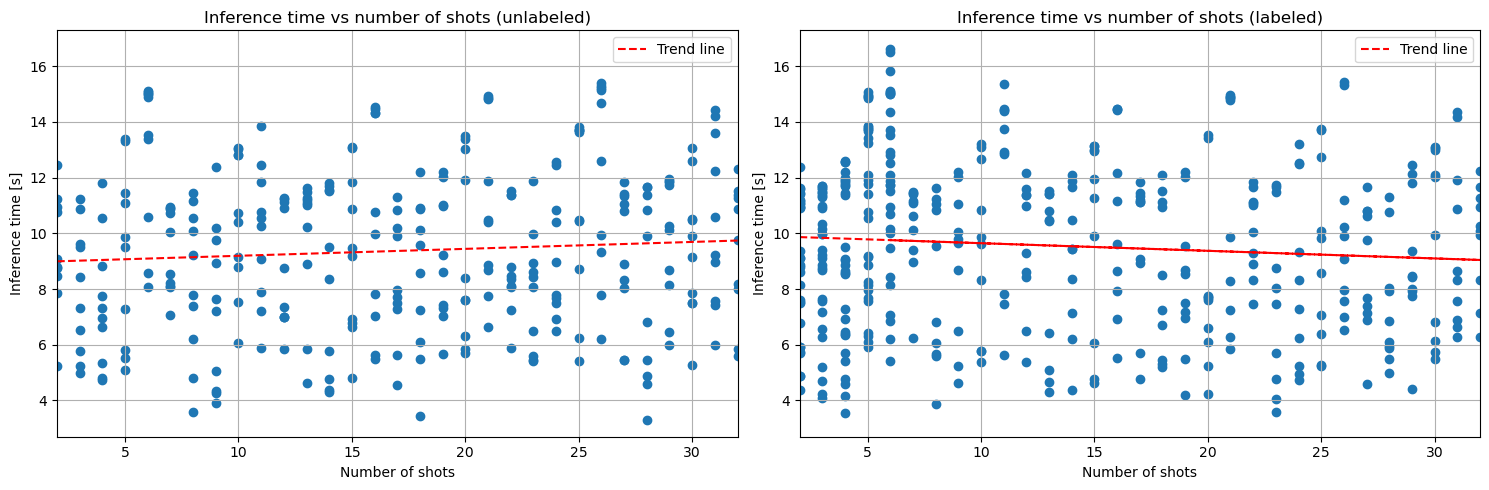

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Left subplot
axs[0].scatter(data_4bit_unlabeled['num_examples'], data_4bit_unlabeled['inference_time'])
axs[0].set_xlabel('Number of shots')
axs[0].set_ylabel('Inference time [s]')
axs[0].set_title('Inference time vs number of shots (unlabeled)')
axs[0].grid()

z = np.polyfit(data_4bit_unlabeled['num_examples'], data_4bit_unlabeled['inference_time'], 1)
p = np.poly1d(z)
axs[0].plot(data_4bit_unlabeled['num_examples'], p(data_4bit_unlabeled['num_examples']), "r--", label='Trend line')
axs[0].legend()

# Right subplot
axs[1].scatter(data_4bit_labeled['num_examples'], data_4bit_labeled['inference_time'])
axs[1].set_xlabel('Number of shots')
axs[1].set_ylabel('Inference time [s]')
axs[1].set_title('Inference time vs number of shots (labeled)')
axs[1].grid()

z = np.polyfit(data_4bit_labeled['num_examples'], data_4bit_labeled['inference_time'], 1)
p = np.poly1d(z)
axs[1].plot(data_4bit_labeled['num_examples'], p(data_4bit_labeled['num_examples']), "r--", label='Trend line')
axs[1].legend()

# Set the same y-axis limits for both subplots
y_min = min(axs[0].get_ylim()[0], axs[1].get_ylim()[0])
y_max = max(axs[0].get_ylim()[1], axs[1].get_ylim()[1])
axs[0].set_ylim(y_min, y_max)
axs[0].set_xlim(2, 32)
axs[1].set_ylim(y_min, y_max)
axs[1].set_xlim(2, 32)

plt.tight_layout()
plt.savefig('inf_time.pdf', format='pdf')
plt.show()

#### Memory usage

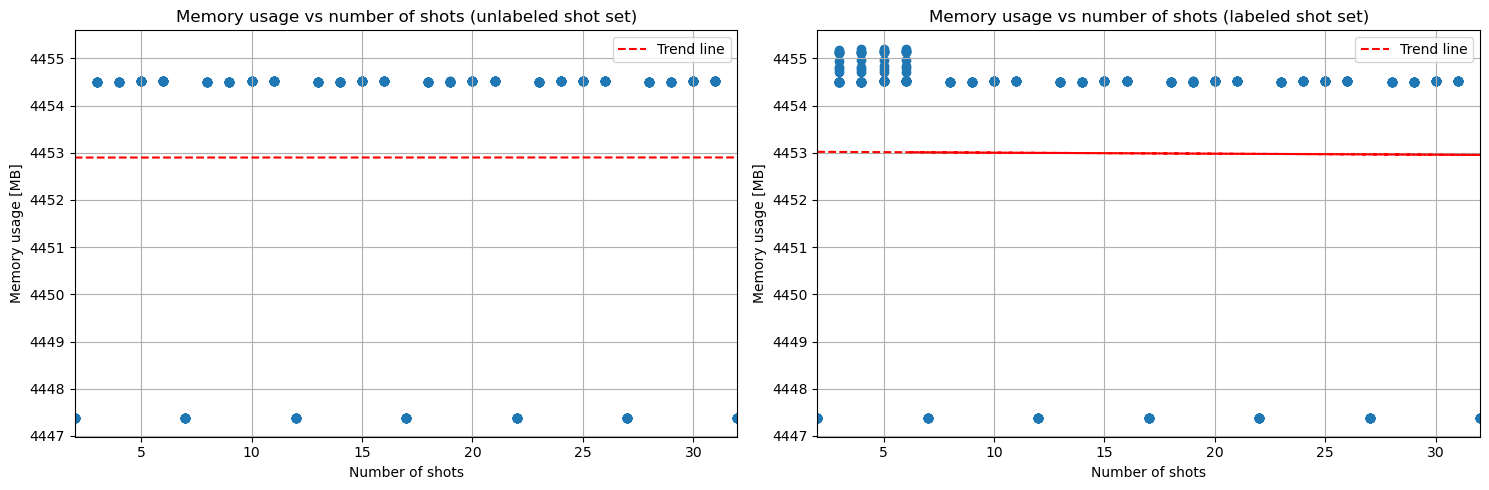

In [8]:
# plot memory usage + input size vs number of shots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Left subplot
axs[0].scatter(df_4bit_unlabeled['num_examples'], df_4bit_unlabeled['total_memory_usage'])
axs[0].set_xlabel('Number of shots')
axs[0].set_ylabel('Memory usage [MB]')
axs[0].set_title('Memory usage vs number of shots (unlabeled shot set)')
axs[0].grid()

z = np.polyfit(df_4bit_unlabeled['num_examples'], df_4bit_unlabeled['total_memory_usage'], 1)
p = np.poly1d(z)
axs[0].plot(df_4bit_unlabeled['num_examples'], p(df_4bit_unlabeled['num_examples']), "r--", label='Trend line')
axs[0].legend()

# Right subplot
axs[1].scatter(df_4bit_labeled['num_examples'], df_4bit_labeled['total_memory_usage'])
axs[1].set_xlabel('Number of shots')
axs[1].set_ylabel('Memory usage [MB]')
axs[1].set_title('Memory usage vs number of shots (labeled shot set)')
axs[1].grid()

z = np.polyfit(df_4bit_labeled['num_examples'], df_4bit_labeled['total_memory_usage'], 1)
p = np.poly1d(z)
axs[1].plot(df_4bit_labeled['num_examples'], p(df_4bit_labeled['num_examples']), "r--", label='Trend line')
axs[1].legend()

# Set the same y-axis limits for both subplots
y_min = min(axs[0].get_ylim()[0], axs[1].get_ylim()[0])
y_max = max(axs[0].get_ylim()[1], axs[1].get_ylim()[1])
axs[0].set_ylim(y_min, y_max)
axs[0].set_xlim(2, 32)
axs[1].set_ylim(y_min, y_max)
axs[1].set_xlim(2, 32)

plt.tight_layout()
plt.savefig('mem_usage.pdf', format='pdf')
plt.show()

#### Input size

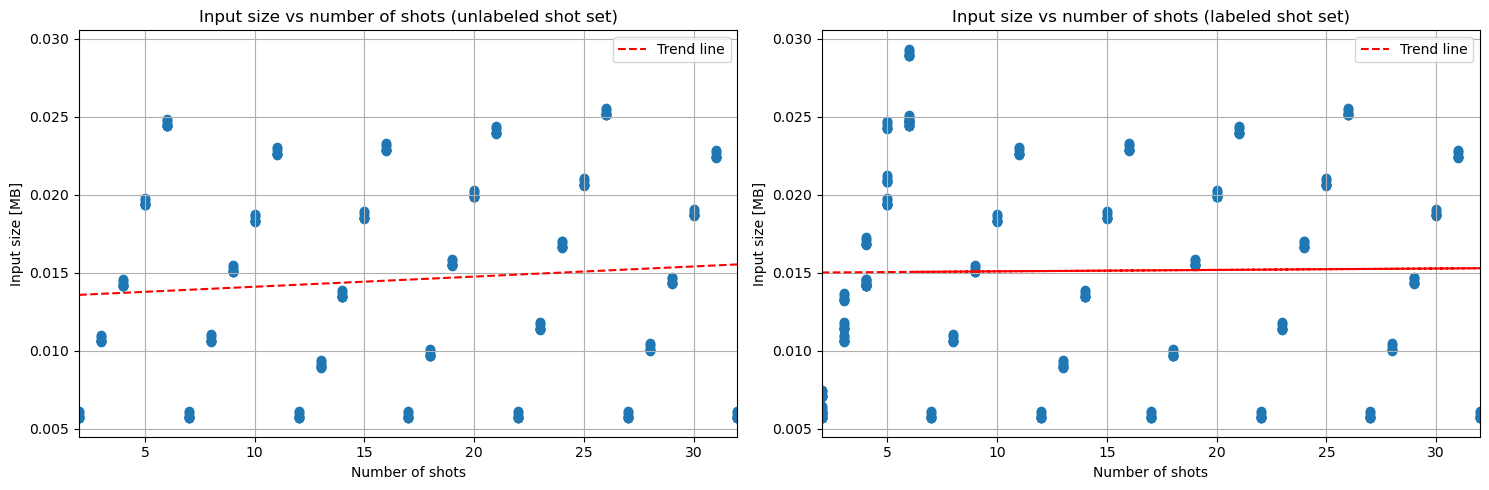

In [9]:
# create a scatter plot of input_size vs number of shots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Left subplot
axs[0].scatter(df_4bit_unlabeled['num_examples'], df_4bit_unlabeled['input_size'])
axs[0].set_xlabel('Number of shots')
axs[0].set_ylabel('Input size [MB]')
axs[0].set_title('Input size vs number of shots (unlabeled shot set)')
axs[0].grid()

z = np.polyfit(df_4bit_unlabeled['num_examples'], df_4bit_unlabeled['input_size'], 1)
p = np.poly1d(z)
axs[0].plot(df_4bit_unlabeled['num_examples'], p(df_4bit_unlabeled['num_examples']), "r--", label='Trend line')
axs[0].legend()

# Right subplot
axs[1].scatter(df_4bit_labeled['num_examples'], df_4bit_labeled['input_size'])
axs[1].set_xlabel('Number of shots')
axs[1].set_ylabel('Input size [MB]')
axs[1].set_title('Input size vs number of shots (labeled shot set)')
axs[1].grid()

z = np.polyfit(df_4bit_labeled['num_examples'], df_4bit_labeled['input_size'], 1)
p = np.poly1d(z)
axs[1].plot(df_4bit_labeled['num_examples'], p(df_4bit_labeled['num_examples']), "r--", label='Trend line')
axs[1].legend()

# Set the same y-axis limits for both subplots
y_min = min(axs[0].get_ylim()[0], axs[1].get_ylim()[0])
y_max = max(axs[0].get_ylim()[1], axs[1].get_ylim()[1])
for ax in axs:
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(2, 32)

plt.tight_layout()
plt.savefig('inputs.pdf', format='pdf')
plt.show()


# Mistral output plots

In [10]:
sol_instances_dicts = []
sol_predicates_dicts = []
sol_goals_dicts = []

counter = 1

for sols in solutions_unlabeled:
    counter+=1
    
    instances = sols.split('predicate')[0]
    predicates = sols.split('goal ')[0].replace(instances, '')
    goals = sols.replace(instances + predicates, '')

    instances = instances.replace("|", " |")
    predicates = predicates.replace("|", " |")
    goals = goals.replace("|", " |")

    instances = instances.split()
    predicates = predicates.split()
    goals = goals.split()

    # iterate over the words in instances, predicates and goals and delete the char | where is is
    for i in range(len(instances)):
        instances[i] = instances[i].replace("|", "")
    for i in range(len(predicates)):
        predicates[i] = predicates[i].replace("|", "")
    for i in range(len(goals)):
        goals[i] = goals[i].replace("|", "")

    # remove the empty strings from the lists
    instances = list(filter(None, instances))
    predicates = list(filter(None, predicates))
    goals = list(filter(None, goals))

    # create instances dictionary
    instances_dict = {}
    key = None
    for word in instances:
        if word == 'instance':
            if key is not None:
                if key in instances_dict:
                    print(f'Key {key} already exists in instances {counter}.')
                    key = key+'_copy'
                    instances_dict[key] = value
                else:
                    instances_dict[key] = value
            key = None
            value = None
        elif key is None:
            key = word
        else:
            value = word
    if key is not None:
        if key in instances_dict:
            print(f'Key {key} already exists in instances {counter}.')
            key = key+'_copy'
            instances_dict[key] = value
        else:    
            instances_dict[key] = value

    # create predicates dictionary
    predicates_dict = {}
    key = ''
    value = ''
    for i in range(len(predicates)):
        if predicates[i] == 'predicate':
            if key:
                if key in predicates_dict:
                    print(f"Key {key} already exists in predicates {counter}.")
                    key = key+'_copy'
                    predicates_dict[key] = value
                else:
                    predicates_dict[key] = value

            value = predicates[i+1] 
            key = ' '.join(predicates[i+2:])  
            next_predicate_index = key.find('predicate') 
            if next_predicate_index != -1:
                key = key[:next_predicate_index].strip()
    if key:
        if key in predicates_dict:
            print(f"Key {key} already exists in predicates {counter}.")
            key = key+'_copy'
            predicates_dict[key] = value
        else:
            predicates_dict[key] = value

    # create goals dictionary
    goals_dict = {}
    key = ''
    value = ''
    for i in range(len(goals)):
        if goals[i] == 'goal':
            if key:
                if key in goals_dict:
                    print(f"Key {key} already exists in goals {counter}.")
                    key = key+'_copy'
                    goals_dict[key] = value
                else:
                    goals_dict[key] = value

            value = goals[i+1] 
            key = ' '.join(goals[i+2:])  
            next_goal_index = key.find('goal') 
            if next_goal_index != -1:
                key = key[:next_goal_index].strip()
    if key:
        if key in goals_dict:
            print(f"Key {key} already exists in goals {counter}.")
            key = key+'_copy'
            goals_dict[key] = value
        else:
            goals_dict[key] = value

    sol_instances_dicts.append(instances_dict)
    sol_predicates_dicts.append(predicates_dict)
    sol_goals_dicts.append(goals_dict)

solution_instances = np.array(sol_instances_dicts)
solution_predicates = np.array(sol_predicates_dicts)
solution_goals = np.array(sol_goals_dicts)

Key book1 already exists in goals 9.


In [11]:
counter = 0
num_of_ex_list = []

with open('output_results_unlabeled.txt', 'w') as f:
    for i in range(len(sliced_outputs_unlabeled)):        
        for j in range(len(sliced_outputs_unlabeled[i])):
            instance_count_out = sliced_outputs_unlabeled[i][j].count('instance')
            predicate_count_out = sliced_outputs_unlabeled[i][j].count('predicate')
            goal_count_out = sliced_outputs_unlabeled[i][j].count('goal')

            instance_count_sol = solutions_unlabeled[i].count('instance')
            predicate_count_sol = solutions_unlabeled[i].count('predicate')
            goal_count_sol = solutions_unlabeled[i].count('goal')

            if instance_count_out==instance_count_sol and predicate_count_out==predicate_count_sol and goal_count_out==goal_count_sol:
                counter+=1
                num_of_ex_list.append(j+2)

            f.write(f'Test set {i+1} - number of examples {j+2}\n')
            f.write(f'{sliced_outputs_unlabeled[i][j]}\n')
            f.write(f'{solutions_unlabeled[i]}\n')
            f.write(f'instances: {instance_count_out}/{instance_count_sol} - predicate count: {predicate_count_out}/{predicate_count_sol} - goal count: {goal_count_out}/{goal_count_sol}\n\n')

# count the number of times each number of examples appears
num_of_ex_list = np.array(num_of_ex_list)
unique, counts = np.unique(num_of_ex_list, return_counts=True)
# print(np.asarray((unique, counts)).T)

out_instances_dicts_unlabeled = [[] for _ in range(len(sliced_outputs_unlabeled))]
out_predicates_dicts_unlabeled = [[] for _ in range(len(sliced_outputs_unlabeled))]
out_goals_dicts_unlabeled = [[] for _ in range(len(sliced_outputs_unlabeled))]

counter = 1

for i in range(len(sliced_outputs_unlabeled)):        
    for j in range(len(sliced_outputs_unlabeled[i])):
        instances = sliced_outputs_unlabeled[i][j].split('predicate')[0]
        predicates = sliced_outputs_unlabeled[i][j].split('goal ')[0].replace(instances, '')
        goals = sliced_outputs_unlabeled[i][j].replace(instances + predicates, '')

        instances = instances.replace("|", " |")
        predicates = predicates.replace("|", " |")
        goals = goals.replace("|", " |")

        instances = instances.split()
        predicates = predicates.split()
        goals = goals.split()

        # iterate over the words in instances, predicates and goals and delete the char | where is is
        for k in range(len(instances)):
            instances[k] = instances[k].replace("|", "")
        for k in range(len(predicates)):
            predicates[k] = predicates[k].replace("|", "")
        for k in range(len(goals)):
            goals[k] = goals[k].replace("|", "")

        # remove the empty strings from the lists
        instances = list(filter(None, instances))
        predicates = list(filter(None, predicates))
        goals = list(filter(None, goals))

        # create instances dictionary
        instances_dict = {}
        key = None
        for word in instances:
            if word == 'instance':
                if key is not None:
                    if key in instances_dict:
                        # print(f'Key {key} already exists in instances {counter}.')
                        key = key+'_copy'
                        instances_dict[key] = value
                    else:
                        instances_dict[key] = value
                key = None
                value = None
            elif key is None:
                key = word
            else:
                value = word
        if key is not None:
            if key in instances_dict:
                # print(f'Key {key} already exists in instances {counter}.')
                key = key+'_copy'
                instances_dict[key] = value
            else:    
                instances_dict[key] = value

        # create predicates dictionary
        predicates_dict = {}
        key = ''
        value = ''
        for n in range(len(predicates)):
            if predicates[n] == 'predicate':
                if key:
                    if key in predicates_dict:
                        # print(f"Key {key} already exists in predicates {counter}.")
                        key = key+'_copy'
                        predicates_dict[key] = value
                    else:
                        predicates_dict[key] = value

                value = predicates[n+1] 
                key = ' '.join(predicates[n+2:])  
                next_predicate_index = key.find('predicate') 
                if next_predicate_index != -1:
                    key = key[:next_predicate_index].strip()
        if key:
            if key in predicates_dict:
                # print(f"Key {key} already exists in predicates {counter}.")
                key = key+'_copy'
                predicates_dict[key] = value
            else:
                predicates_dict[key] = value

        # create goals dictionary
        goals_dict = {}
        key = ''
        value = ''
        for n in range(len(goals)):
            if goals[n] == 'goal':
                if key:
                    if key in goals_dict:
                        # print(f"Key {key} already exists in goals {counter}.")
                        key = key+'_copy'
                        goals_dict[key] = value
                    else:
                        goals_dict[key] = value

                value = goals[n+1] 
                key = ' '.join(goals[n+2:])  
                next_goal_index = key.find('goal') 
                if next_goal_index != -1:
                    key = key[:next_goal_index].strip()
        if key:
            if key in goals_dict:
                # print(f"Key {key} already exists in goals {counter}.")
                key = key+'_copy'
                goals_dict[key] = value
            else:
                goals_dict[key] = value

        out_instances_dicts_unlabeled[i].append(instances_dict)
        out_predicates_dicts_unlabeled[i].append(predicates_dict)
        out_goals_dicts_unlabeled[i].append(goals_dict)

with open('compare_instances_unlabeled.txt', 'w') as f:
    for i in range(len(sol_instances_dicts)):
        for j in range(len(out_instances_dicts_unlabeled[i])):
            f.write(f'======================================== Examples {j+2} - {i+1} ========================================\n')
            f.write(f'                      Solution                                              Output\n')
            f.write(f'-------------------------------------------------------------------------------------------------\n')

            sol_keys = list(sol_instances_dicts[i].keys())
            out_keys = list(out_instances_dicts_unlabeled[i][j].keys())

            max_len = max(len(sol_keys), len(out_keys))

            for k in range(max_len):
                sol_key = sol_keys[k] if k < len(sol_keys) else ''
                sol_value = sol_instances_dicts[i].get(sol_key, '')
                out_key = out_keys[k] if k < len(out_keys) else ''
                out_value = out_instances_dicts_unlabeled[i][j].get(out_key, '')

                sol_str = f'{sol_key:>26}: {sol_value:<37}'
                out_str = f'{out_key:>13}: {out_value}'
                f.write(f'{sol_str}{out_str}\n')
                f.write(f'-------------------------------------------------------------------------------------------------\n')

            f.write(f'\n\n')

with open('compare_predicates_unlabeled.txt', 'w') as f:
    for i in range(len(sol_predicates_dicts)):        
        for j in range(len(out_predicates_dicts_unlabeled[i])):
            f.write(f'======================================== Examples {j+2} - {i+1} ========================================\n')
            f.write(f'                      Solution                                              Output\n')
            f.write(f'-------------------------------------------------------------------------------------------------\n')

            sol_keys = list(sol_predicates_dicts[i].keys())
            out_keys = list(out_predicates_dicts_unlabeled[i][j].keys())

            max_len = max(len(sol_keys), len(out_keys))

            for k in range(max_len):
                sol_key = sol_keys[k] if k < len(sol_keys) else ''
                sol_value = sol_predicates_dicts[i].get(sol_key, '')
                out_key = out_keys[k] if k < len(out_keys) else ''
                out_value = out_predicates_dicts_unlabeled[i][j].get(out_key, '')

                sol_str = f'{sol_key:>26}: {sol_value:<37}'
                out_str = f'{out_key:>13}: {out_value}'
                f.write(f'{sol_str}{out_str}\n')
                f.write(f'-------------------------------------------------------------------------------------------------\n')

            f.write(f'\n\n')

with open('compare_goals_unlabeled.txt', 'w') as f:
    for i in range(len(sol_goals_dicts)):
        for j in range(len(out_goals_dicts_unlabeled[i])):
            f.write(f'======================================== Examples {j+2} - {i+1} ========================================\n')
            f.write(f'                      Solution                                              Output\n')
            f.write(f'-------------------------------------------------------------------------------------------------\n')

            sol_keys = list(sol_goals_dicts[i].keys())
            out_keys = list(out_goals_dicts_unlabeled[i][j].keys())

            max_len = max(len(sol_keys), len(out_keys))

            for k in range(max_len):
                sol_key = sol_keys[k] if k < len(sol_keys) else ''
                sol_value = sol_goals_dicts[i].get(sol_key, '')
                out_key = out_keys[k] if k < len(out_keys) else ''
                out_value = out_goals_dicts_unlabeled[i][j].get(out_key, '')

                sol_str = f'{sol_key:>26}: {sol_value:<37}'
                out_str = f'{out_key:>13}: {out_value}'
                f.write(f'{sol_str}{out_str}\n')
                f.write(f'-------------------------------------------------------------------------------------------------\n')

            f.write(f'\n\n')

for i in range(len(out_instances_dicts_unlabeled)):
    for j in range(len(out_instances_dicts_unlabeled[i])):
        instance_dict = {}
        for key, value in list(out_instances_dicts_unlabeled[i][j].items()):
            if value is not None:
                new_key = key.replace('\\', '').replace('/', '').replace('"', '').replace('#', '').replace(':', '').lower()
                new_value = value.replace('\\', '').replace('/', '').replace('"', '').replace('#', '').replace(':', '').lower()
                instance_dict[new_key] = new_value
        out_instances_dicts_unlabeled[i][j] = instance_dict

for i in range(len(out_predicates_dicts_unlabeled)):
    for j in range(len(out_predicates_dicts_unlabeled[i])):
        predicate_dict = {}
        for key, value in out_predicates_dicts_unlabeled[i][j].items():
            if value is not None:
                new_key = key.replace('\\', '').replace('/', '').replace('"', '').replace('#', '').replace(':', '').lower()
                new_value = value.replace('\\', '').replace('/', '').replace('"', '').replace('#', '').replace(':', '').lower()
                predicate_dict[new_key] = new_value
        out_predicates_dicts_unlabeled[i][j] = predicate_dict

for i in range(len(out_goals_dicts_unlabeled)):
    for j in range(len(out_goals_dicts_unlabeled[i])):
        goals_dict = {}
        for key, value in out_goals_dicts_unlabeled[i][j].items():
            if value is not None:
                new_key = key.replace('\\', '').replace('/', '').replace('"', '').replace('#', '').replace(':', '').lower()
                new_value = value.replace('\\', '').replace('/', '').replace('"', '').replace('#', '').replace(':', '').lower()
                goals_dict[new_key] = new_value
        out_goals_dicts_unlabeled[i][j] = goals_dict

instances_unlabeled = np.array(out_instances_dicts_unlabeled)
predicates_unlabeled = np.array(out_predicates_dicts_unlabeled)
goals_unlabeled = np.array(out_goals_dicts_unlabeled)

In [12]:
counter = 0
num_of_ex_list = []

with open('output_results_labeled.txt', 'w') as f:
    for i in range(len(sliced_outputs_labeled)):        
        for j in range(len(sliced_outputs_labeled[i])):
            instance_count_out = sliced_outputs_labeled[i][j].count('instance')
            predicate_count_out = sliced_outputs_labeled[i][j].count('predicate')
            goal_count_out = sliced_outputs_labeled[i][j].count('goal')

            instance_count_sol = solutions_labeled[i].count('instance')
            predicate_count_sol = solutions_labeled[i].count('predicate')
            goal_count_sol = solutions_labeled[i].count('goal')

            if instance_count_out==instance_count_sol and predicate_count_out==predicate_count_sol and goal_count_out==goal_count_sol:
                counter+=1
                num_of_ex_list.append(j+2)

            f.write(f'Test set {i+1} - number of examples {j+2}\n')
            f.write(f'{sliced_outputs_labeled[i][j]}\n')
            f.write(f'{solutions_labeled[i]}\n')
            f.write(f'instances: {instance_count_out}/{instance_count_sol} - predicate count: {predicate_count_out}/{predicate_count_sol} - goal count: {goal_count_out}/{goal_count_sol}\n\n')

         # count the number of times each number of examples appears
num_of_ex_list = np.array(num_of_ex_list)
unique, counts = np.unique(num_of_ex_list, return_counts=True)
# print(np.asarray((unique, counts)).T)   

out_instances_dicts_labeled = [[] for _ in range(len(sliced_outputs_labeled))]
out_predicates_dicts_labeled = [[] for _ in range(len(sliced_outputs_labeled))]
out_goals_dicts_labeled = [[] for _ in range(len(sliced_outputs_labeled))]

counter = 1

for i in range(len(sliced_outputs_labeled)):        
    for j in range(len(sliced_outputs_labeled[i])):
        instances = sliced_outputs_labeled[i][j].split('predicate')[0]
        predicates = sliced_outputs_labeled[i][j].split('goal ')[0].replace(instances, '')
        goals = sliced_outputs_labeled[i][j].replace(instances + predicates, '')

        instances = instances.replace("|", " |")
        predicates = predicates.replace("|", " |")
        goals = goals.replace("|", " |")

        instances = instances.split()
        predicates = predicates.split()
        goals = goals.split()

        # iterate over the words in instances, predicates and goals and delete the char | where is is
        for k in range(len(instances)):
            instances[k] = instances[k].replace("|", "")
        for k in range(len(predicates)):
            predicates[k] = predicates[k].replace("|", "")
        for k in range(len(goals)):
            goals[k] = goals[k].replace("|", "")

        # remove the empty strings from the lists
        instances = list(filter(None, instances))
        predicates = list(filter(None, predicates))
        goals = list(filter(None, goals))

        # create instances dictionary
        instances_dict = {}
        key = None
        for word in instances:
            if word == 'instance':
                if key is not None:
                    if key in instances_dict:
                        # print(f'Key {key} already exists in instances {counter}.')
                        key = key+'_copy'
                        instances_dict[key] = value
                    else:
                        instances_dict[key] = value
                key = None
                value = None
            elif key is None:
                key = word
            else:
                value = word
        if key is not None:
            if key in instances_dict:
                # print(f'Key {key} already exists in instances {counter}.')
                key = key+'_copy'
                instances_dict[key] = value
            else:    
                instances_dict[key] = value

        # create predicates dictionary
        predicates_dict = {}
        key = ''
        value = ''
        for n in range(len(predicates)):
            if predicates[n] == 'predicate':
                if key:
                    if key in predicates_dict:
                        # print(f"Key {key} already exists in predicates {counter}.")
                        key = key+'_copy'
                        predicates_dict[key] = value
                    else:
                        predicates_dict[key] = value

                if n+1 < len(predicates):
                    value = predicates[n+1] 
                    key = ' '.join(predicates[n+2:])  
                    next_predicate_index = key.find('predicate') 
                    if next_predicate_index != -1:
                        key = key[:next_predicate_index].strip()
        if key:
            if key in predicates_dict:
                # print(f"Key {key} already exists in predicates {counter}.")
                key = key+'_copy'
                predicates_dict[key] = value
            else:
                predicates_dict[key] = value

        # create goals dictionary
        goals_dict = {}
        key = ''
        value = ''
        for n in range(len(goals)):
            if goals[n] == 'goal':
                if key:
                    if key in goals_dict:
                        # print(f"Key {key} already exists in goals {counter}.")
                        key = key+'_copy'
                        goals_dict[key] = value
                    else:
                        goals_dict[key] = value

                value = goals[n+1] 
                key = ' '.join(goals[n+2:])  
                next_goal_index = key.find('goal') 
                if next_goal_index != -1:
                    key = key[:next_goal_index].strip()
        if key:
            if key in goals_dict:
                # print(f"Key {key} already exists in goals {counter}.")
                key = key+'_copy'
                goals_dict[key] = value
            else:
                goals_dict[key] = value

        out_instances_dicts_labeled[i].append(instances_dict)
        out_predicates_dicts_labeled[i].append(predicates_dict)
        out_goals_dicts_labeled[i].append(goals_dict)

with open('compare_instances_labeled.txt', 'w') as f:
    for i in range(len(sol_instances_dicts)):
        for j in range(len(out_instances_dicts_labeled[i])):
            f.write(f'======================================== Examples {j+2} - {i+1} ========================================\n')
            f.write(f'                      Solution                                              Output\n')
            f.write(f'-------------------------------------------------------------------------------------------------\n')

            sol_keys = list(sol_instances_dicts[i].keys())
            out_keys = list(out_instances_dicts_labeled[i][j].keys())

            max_len = max(len(sol_keys), len(out_keys))

            for k in range(max_len):
                sol_key = sol_keys[k] if k < len(sol_keys) else ''
                sol_value = sol_instances_dicts[i].get(sol_key, '')
                out_key = out_keys[k] if k < len(out_keys) else ''
                out_value = out_instances_dicts_labeled[i][j].get(out_key, '')

                sol_str = f'{sol_key:>26}: {sol_value:<37}'
                out_str = f'{out_key:>13}: {out_value}'
                f.write(f'{sol_str}{out_str}\n')
                f.write(f'-------------------------------------------------------------------------------------------------\n')

            f.write(f'\n\n')

with open('compare_predicates_labeled.txt', 'w') as f:
    for i in range(len(sol_predicates_dicts)):        
        for j in range(len(out_predicates_dicts_labeled[i])):
            f.write(f'======================================== Examples {j+2} - {i+1} ========================================\n')
            f.write(f'                      Solution                                              Output\n')
            f.write(f'-------------------------------------------------------------------------------------------------\n')

            sol_keys = list(sol_predicates_dicts[i].keys())
            out_keys = list(out_predicates_dicts_labeled[i][j].keys())

            max_len = max(len(sol_keys), len(out_keys))

            for k in range(max_len):
                sol_key = sol_keys[k] if k < len(sol_keys) else ''
                sol_value = sol_predicates_dicts[i].get(sol_key, '')
                out_key = out_keys[k] if k < len(out_keys) else ''
                out_value = out_predicates_dicts_labeled[i][j].get(out_key, '')

                sol_str = f'{sol_key:>26}: {sol_value:<37}'
                out_str = f'{out_key:>13}: {out_value}'
                f.write(f'{sol_str}{out_str}\n')
                f.write(f'-------------------------------------------------------------------------------------------------\n')

            f.write(f'\n\n')

with open('compare_goals_labeled.txt', 'w') as f:
    for i in range(len(sol_goals_dicts)):
        for j in range(len(out_goals_dicts_labeled[i])):
            f.write(f'======================================== Examples {j+2} - {i+1} ========================================\n')
            f.write(f'                      Solution                                              Output\n')
            f.write(f'-------------------------------------------------------------------------------------------------\n')

            sol_keys = list(sol_goals_dicts[i].keys())
            out_keys = list(out_goals_dicts_labeled[i][j].keys())

            max_len = max(len(sol_keys), len(out_keys))

            for k in range(max_len):
                sol_key = sol_keys[k] if k < len(sol_keys) else ''
                sol_value = sol_goals_dicts[i].get(sol_key, '')
                out_key = out_keys[k] if k < len(out_keys) else ''
                out_value = out_goals_dicts_labeled[i][j].get(out_key, '')

                sol_str = f'{sol_key:>26}: {sol_value:<37}'
                out_str = f'{out_key:>13}: {out_value}'
                f.write(f'{sol_str}{out_str}\n')
                f.write(f'-------------------------------------------------------------------------------------------------\n')

            f.write(f'\n\n')

for i in range(len(out_instances_dicts_labeled)):
    for j in range(len(out_instances_dicts_labeled[i])):
        instance_dict = {}
        for key, value in list(out_instances_dicts_labeled[i][j].items()):
            if value is not None:
                new_key = key.replace('\\', '').replace('/', '').replace('"', '').replace('#', '').replace(':', '').lower()
                new_value = value.replace('\\', '').replace('/', '').replace('"', '').replace('#', '').replace(':', '').lower()
                instance_dict[new_key] = new_value
        out_instances_dicts_labeled[i][j] = instance_dict

for i in range(len(out_predicates_dicts_labeled)):
    for j in range(len(out_predicates_dicts_labeled[i])):
        predicate_dict = {}
        for key, value in out_predicates_dicts_labeled[i][j].items():
            if value is not None:
                new_key = key.replace('\\', '').replace('/', '').replace('"', '').replace('#', '').replace(':', '').lower()
                new_value = value.replace('\\', '').replace('/', '').replace('"', '').replace('#', '').replace(':', '').lower()
                predicate_dict[new_key] = new_value
        out_predicates_dicts_labeled[i][j] = predicate_dict

for i in range(len(out_goals_dicts_labeled)):
    for j in range(len(out_goals_dicts_labeled[i])):
        goals_dict = {}
        for key, value in out_goals_dicts_labeled[i][j].items():
            if value is not None:
                new_key = key.replace('\\', '').replace('/', '').replace('"', '').replace('#', '').replace(':', '').lower()
                new_value = value.replace('\\', '').replace('/', '').replace('"', '').replace('#', '').replace(':', '').lower()
                goals_dict[new_key] = new_value
        out_goals_dicts_labeled[i][j] = goals_dict

instances_labeled = np.array(out_instances_dicts_labeled)
predicates_labeled = np.array(out_predicates_dicts_labeled)
goals_labeled = np.array(out_goals_dicts_labeled)

#### TP: øker for hver riktige instances i predikering
#### FP: øker om det er en type som ikke skal være der eller om det er flere av en type i prediksjon
#### FN: øker om typen ikke er i predikering eller om det er for få
#### TN: teller ikke

In [13]:
def compare_all_instance_dicts(insts, sol_insts):
    TP = FP = FN = TN = 0

    for i, sublist in enumerate(insts):
        solution_dict = sol_insts[i]
        solution_counter = Counter(solution_dict.values())

        for output_dict in sublist:
            output_counter = Counter(output_dict.values())

            for type, solution_count in solution_counter.items():
                output_count = output_counter.get(type, 0)
                if output_count == solution_count:
                    TP += output_count
                elif output_count < solution_count:
                    TP += output_count
                    FN += solution_count - output_count
                else:  # output_count > solution_count
                    TP += solution_count
                    FP += output_count - solution_count

            for type, output_count in output_counter.items():
                if type not in solution_counter:
                    FP += output_count

    return TP, FP, FN, TN

def compare_instance_dicts(insts, sol_insts):
    results = []

    for i, sublist in enumerate(insts):
        solution_dict = sol_insts[i]
        solution_counter = Counter(solution_dict.values())
        sublist_results = []

        for output_dict in sublist:
            TP = FP = FN = TN = 0
            output_counter = Counter(output_dict.values())

            for type, solution_count in solution_counter.items():
                output_count = output_counter.get(type, 0)
                if output_count == solution_count:
                    TP += output_count
                elif output_count < solution_count:
                    TP += output_count
                    FN += solution_count - output_count
                else:  # output_count > solution_count
                    TP += solution_count
                    FP += output_count - solution_count

            for type, output_count in output_counter.items():
                if type not in solution_counter:
                    FP += output_count

            sublist_results.append((TP, FP, FN, TN))

        results.append(np.array(sublist_results))

    return np.array(results)

def compare_all_predicates_dicts(preds, sol_preds):
    TP = FP = FN = TN = 0

    for i, sublist in enumerate(preds):
        solution_dict = sol_preds[i]

        for output_dict in sublist:
            for output_key, output_value in output_dict.items():
                for solution_key, solution_value in solution_dict.items():
                    if output_value == solution_value and output_key.count(' ') == solution_key.count(' '):
                        TP += 1
                    elif output_value == solution_value and output_key.count(' ') != solution_key.count(' '):
                        FP += 1

            # Count extra predicates in output as FP
            if len(output_dict) > len(solution_dict):
                FP += len(output_dict) - len(solution_dict)

            # Count missing predicates in output as FN
            if len(output_dict) < len(solution_dict):
                FN += len(solution_dict) - len(output_dict)

    return TP, FP, FN, TN

def compare_predicates_dicts(preds, sol_preds):
    results = []

    for i, sublist in enumerate(preds):
        solution_dict = sol_preds[i]

        for output_dict in sublist:
            TP = FP = FN = TN = 0

            for output_key, output_value in output_dict.items():
                for solution_key, solution_value in solution_dict.items():
                    if output_value == solution_value and output_key.count(' ') == solution_key.count(' '):
                        TP += 1
                    elif output_value == solution_value and output_key.count(' ') != solution_key.count(' '):
                        FP += 1

            for solution_value in solution_dict.values():
                if solution_value not in output_dict.values():
                    FN += 1

            results.append((TP, FP, FN, TN))

    results = np.array(results)
    results_split = np.array_split(results, 10)

    return results_split

def compare_all_goal_dicts(goals, sol_goals):
    TP = FP = FN = TN = 0

    for i, sublist in enumerate(goals):
        solution_dict = sol_goals[i]

        for output_dict in sublist:
            for output_key, output_value in output_dict.items():
                for solution_key, solution_value in solution_dict.items():
                    if output_value == solution_value and output_key.count(' ') == solution_key.count(' '):
                        TP += 1
                    elif output_value == solution_value and output_key.count(' ') != solution_key.count(' '):
                        FP += 1

            # Count extra predicates in output as FP
            if len(output_dict) > len(solution_dict):
                FP += len(output_dict) - len(solution_dict)

            # Count missing predicates in output as FN
            if len(output_dict) < len(solution_dict):
                FN += len(solution_dict) - len(output_dict)

    return TP, FP, FN, TN

def compare_goal_dicts(goals, sol_goals):
    results = []

    for i, sublist in enumerate(goals):
        solution_dict = sol_goals[i]

        for output_dict in sublist:
            TP = FP = FN = TN = 0

            for output_key, output_value in output_dict.items():
                for solution_key, solution_value in solution_dict.items():
                    if output_value == solution_value and output_key.count(' ') == solution_key.count(' '):
                        TP += 1
                    elif output_value == solution_value and output_key.count(' ') != solution_key.count(' '):
                        FP += 1

            for solution_value in solution_dict.values():
                if solution_value not in output_dict.values():
                    FN += 1

            results.append((TP, FP, FN, TN))

    results = np.array(results)
    results_split = np.array_split(results, 10)

    return results_split

In [14]:
all_instances_unlabeled = compare_all_instance_dicts(instances_unlabeled, solution_instances)
instances_unlabeled = compare_instance_dicts(instances_unlabeled, solution_instances)
all_predicates_unlabeled = compare_all_predicates_dicts(predicates_unlabeled, solution_predicates)
predicates_unlabeled = compare_predicates_dicts(predicates_unlabeled, solution_predicates)
all_goals_unlabeled = compare_all_goal_dicts(goals_unlabeled, solution_goals)
goals_unlabeled = compare_goal_dicts(goals_unlabeled, solution_goals)

# Average [TP, FP, FN, TN] per shot
inst_avg_unlabeled = np.mean(instances_unlabeled, axis=0)
pred_avg_unlabeled = np.mean(predicates_unlabeled, axis=0)
goal_avg_unlabeled = np.mean(goals_unlabeled, axis=0)
total_avg_unlabeled = np.mean([inst_avg_unlabeled, pred_avg_unlabeled, goal_avg_unlabeled], axis=0)

all_instances_labeled = compare_all_instance_dicts(instances_labeled, solution_instances)
instances_labeled = compare_instance_dicts(instances_labeled, solution_instances)
all_predicates_labeled = compare_all_predicates_dicts(predicates_labeled, solution_predicates)
predicates_labeled = compare_predicates_dicts(predicates_labeled, solution_predicates)
all_goals_labeled = compare_all_goal_dicts(goals_labeled, solution_goals)
goals_labeled = compare_goal_dicts(goals_labeled, solution_goals)

# Average [TP, FP, FN, TN] per shot
inst_avg_labeled = np.mean(instances_labeled, axis=0)
pred_avg_labeled = np.mean(predicates_labeled, axis=0)
goal_avg_labeled = np.mean(goals_labeled, axis=0)
total_avg_labeled = np.mean([inst_avg_labeled, pred_avg_labeled, goal_avg_labeled], axis=0)

#### F1-score, precision and recall

In [15]:
def metrics(avg):
    '''
    Compute precision, recall, f1 and accuracy for the average
    [TP, FP, FN, TN] per shot.
    '''
    epsilon = 1e-7
    precision = avg[:, 0] / (avg[:, 0] + avg[:, 1] + epsilon)
    recall = avg[:, 0] / (avg[:, 0] + avg[:, 2] + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    accuracy = (avg[:, 0] + avg[:, 3]) / (np.sum(avg, axis=1) + epsilon)

    return precision, recall, f1, accuracy

inst_precision_unlabeled, inst_recall_unlabeled, inst_f1_unlabeled, inst_accuracy_unlabeled = metrics(inst_avg_unlabeled)
pred_precision_unlabeled, pred_recall_unlabeled, pred_f1_unlabeled, pred_accuracy_unlabeled = metrics(pred_avg_unlabeled)
goal_precision_unlabeled, goal_recall_unlabeled, goal_f1_unlabeled, goal_accuracy_unlabeled = metrics(goal_avg_unlabeled)
total_precision_unlabeled, total_recall_unlabeled, total_f1_unlabeled, total_accuracy_unlabeled = metrics(total_avg_unlabeled)

inst_precision_labeled, inst_recall_labeled, inst_f1_labeled, inst_accuracy_labeled = metrics(inst_avg_labeled)
pred_precision_labeled, pred_recall_labeled, pred_f1_labeled, pred_accuracy_labeled = metrics(pred_avg_labeled)
goal_precision_labeled, goal_recall_labeled, goal_f1_labeled, goal_accuracy_labeled = metrics(goal_avg_labeled)
total_precision_labeled, total_recall_labeled, total_f1_labeled, total_accuracy_labeled = metrics(total_avg_labeled)

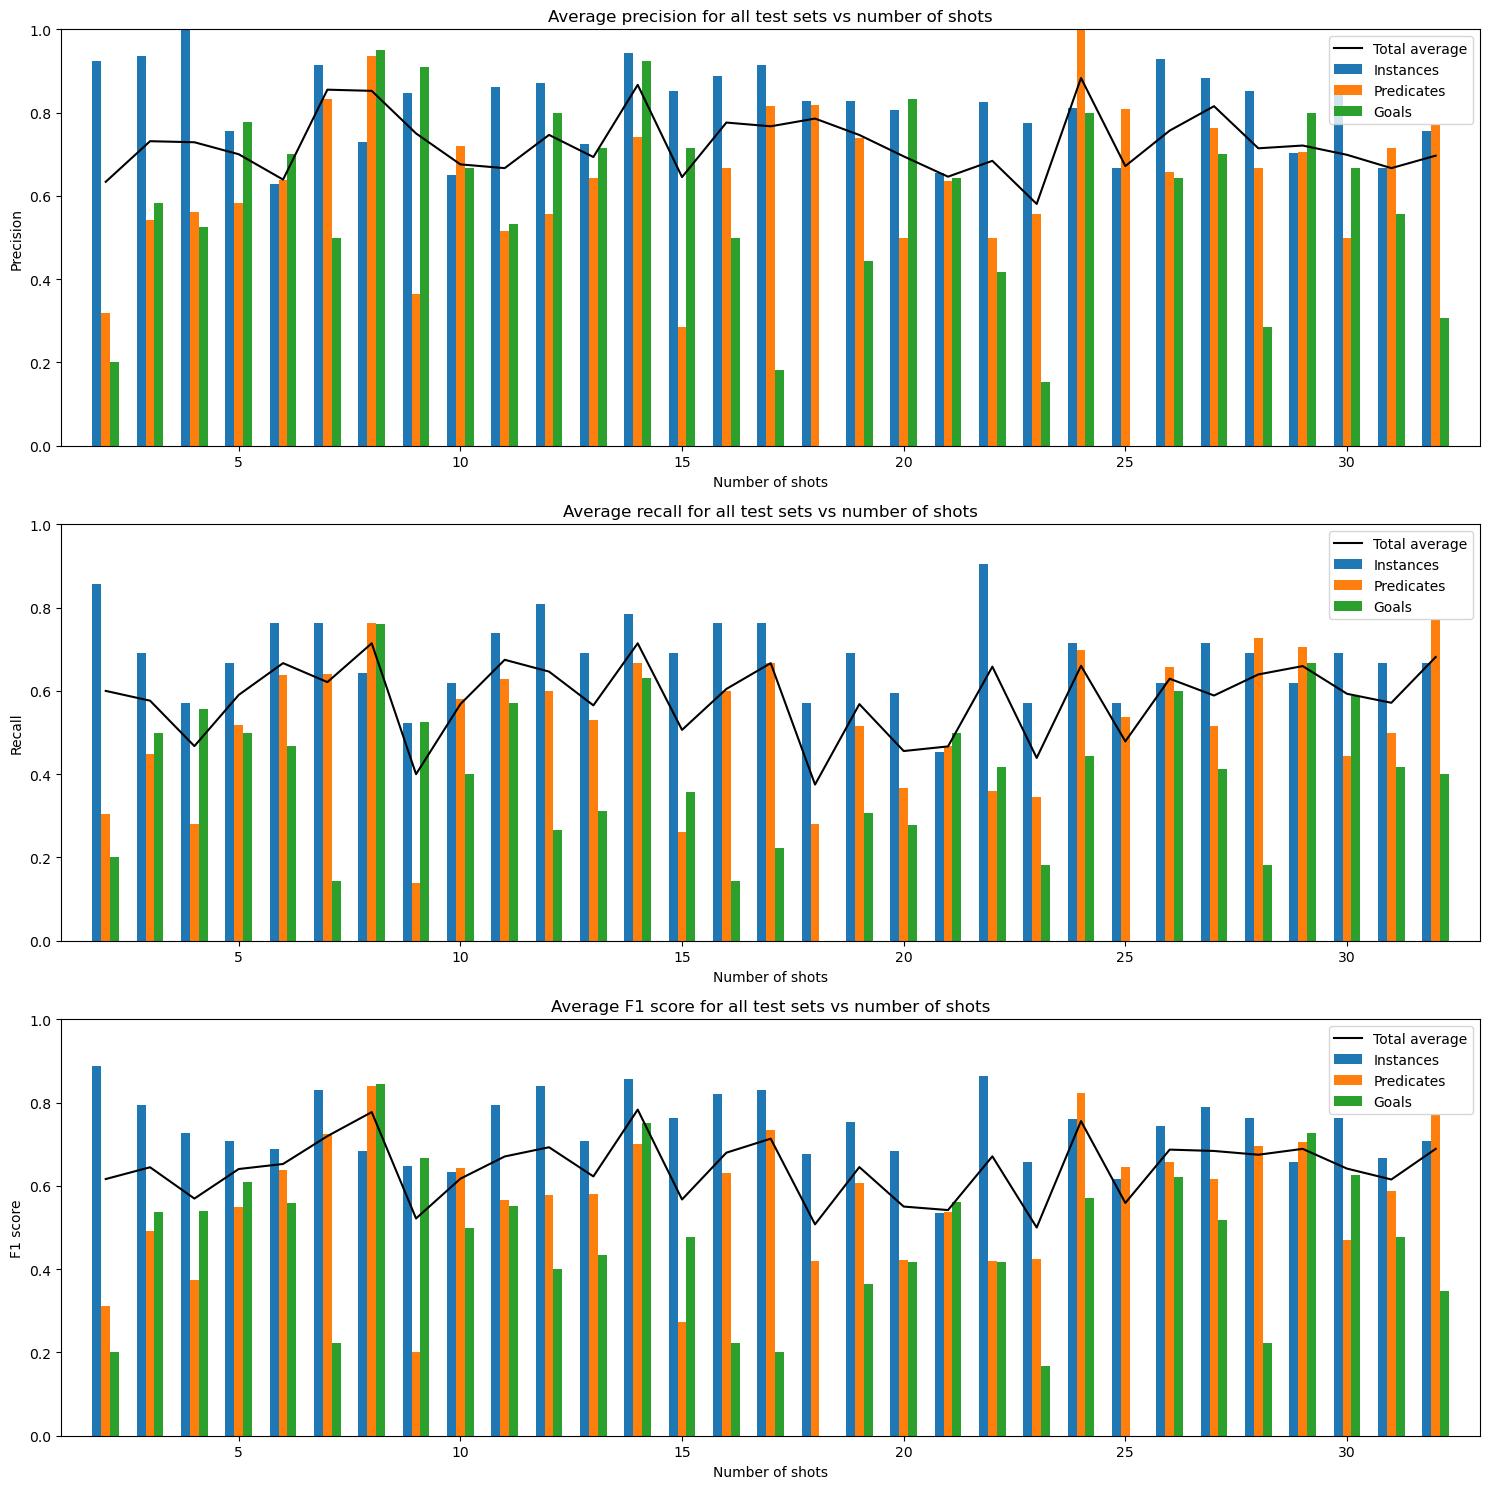

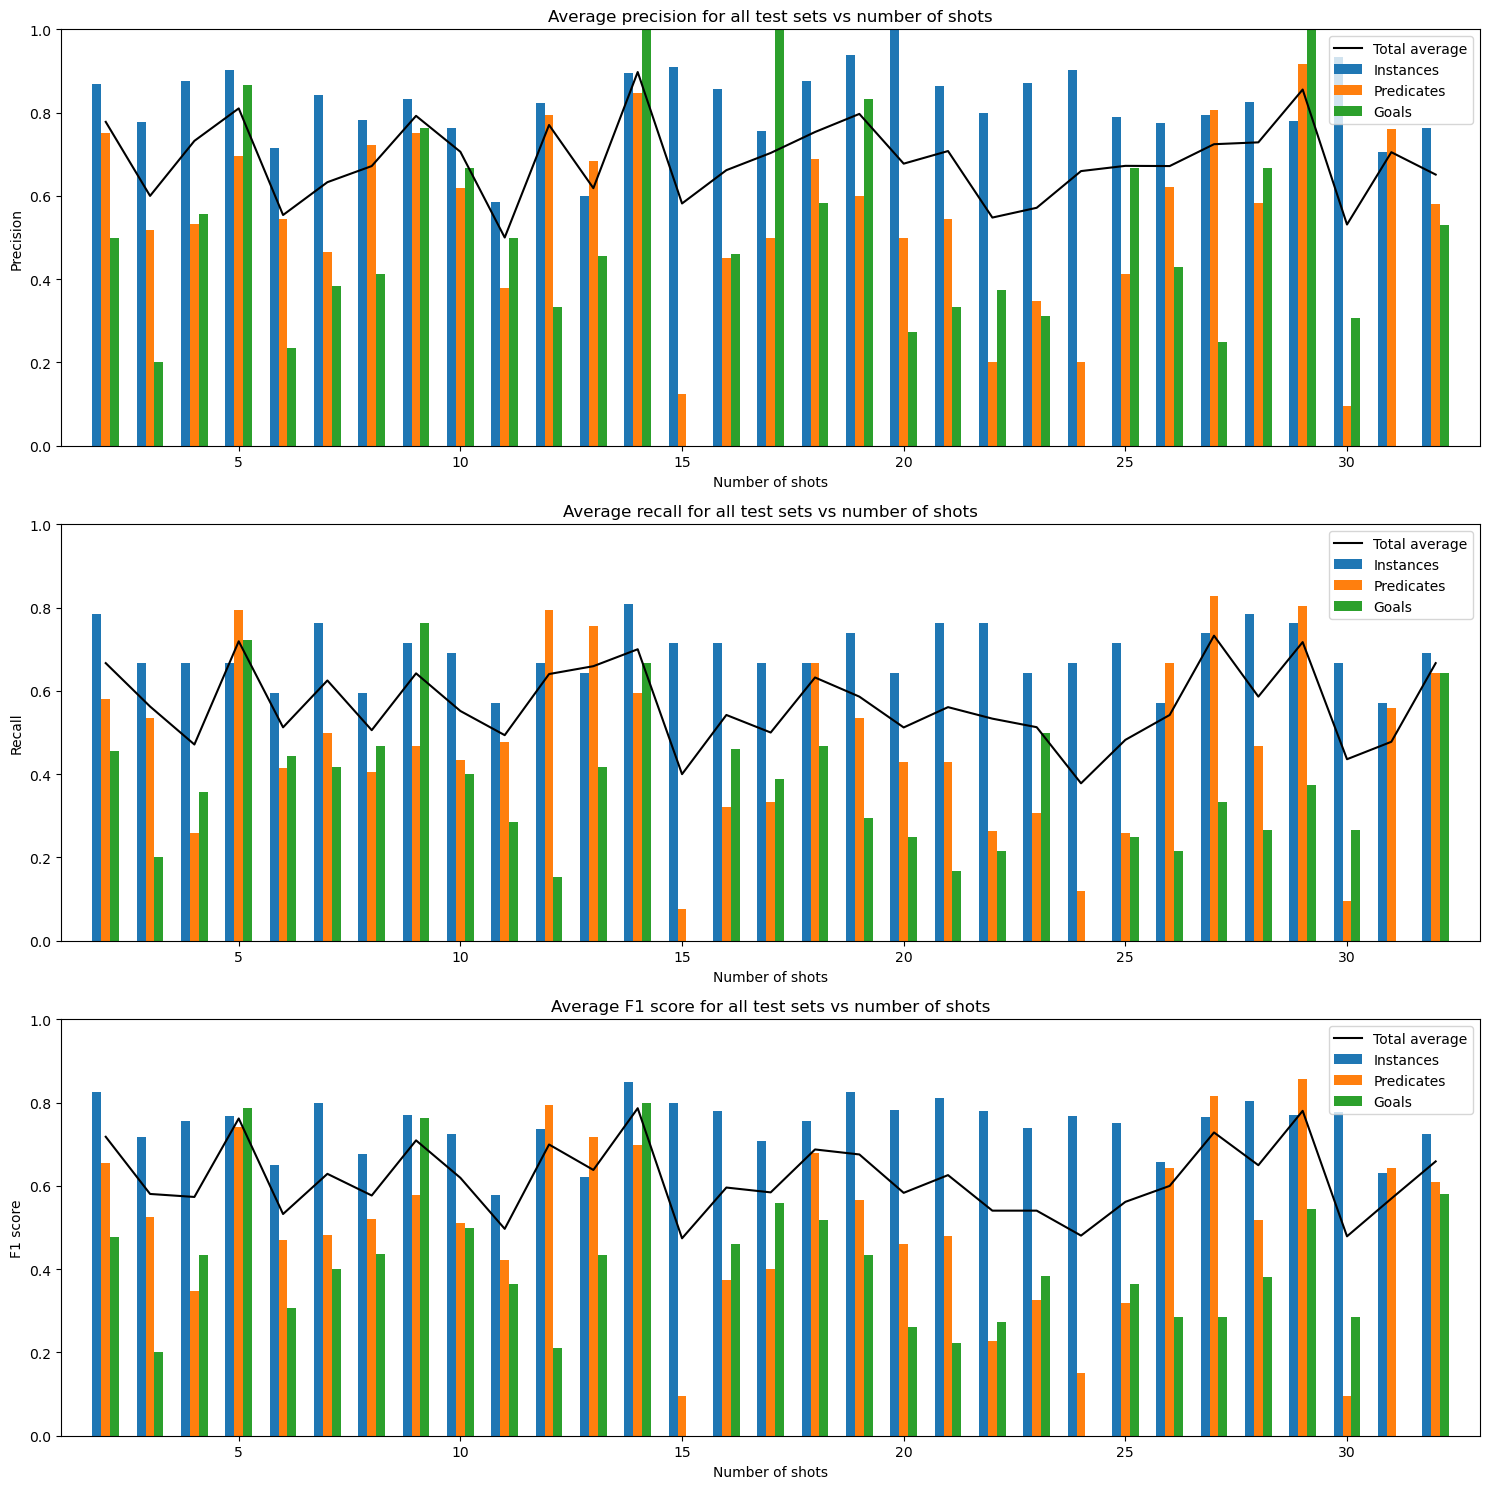

In [16]:
def grouped_bar_plot_metrics(ax, instance, predicate, goal, total, type):
    bar_width = 0.2
    bar_positions = np.arange(2, 33)

    ax.bar(bar_positions - bar_width, instance, width=bar_width, label='Instances')
    ax.bar(bar_positions, predicate, width=bar_width, label='Predicates')
    ax.bar(bar_positions + bar_width, goal, width=bar_width, label='Goals')

    ax.plot(bar_positions, total, label='Total average', color='black')

    label = ['precision', 'recall', 'F1 score']

    ax.set_xlabel('Number of shots')
    ax.set_ylabel(f'{label[type][0].upper() + label[type][1:]}')
    ax.set_title(f'Average {label[type]} for all test sets vs number of shots')
    ax.legend()

    ax.set_ylim(0, 1)
    ax.set_xlim(1, 33)

    return

fig, axs = plt.subplots(3, 1, figsize=(15, 15)) 

grouped_bar_plot_metrics(axs[0], inst_precision_unlabeled, pred_precision_unlabeled, goal_precision_unlabeled, total_precision_unlabeled, 0)
grouped_bar_plot_metrics(axs[1], inst_recall_unlabeled, pred_recall_unlabeled, goal_recall_unlabeled, total_recall_unlabeled, 1)
grouped_bar_plot_metrics(axs[2], inst_f1_unlabeled, pred_f1_unlabeled, goal_f1_unlabeled, total_f1_unlabeled, 2)

plt.tight_layout()
plt.savefig('all_metrics_unlabeled.pdf', format='pdf')
plt.show()

fig, axs = plt.subplots(3, 1, figsize=(15, 15)) 

grouped_bar_plot_metrics(axs[0], inst_precision_labeled, pred_precision_labeled, goal_precision_labeled, total_precision_labeled, 0)
grouped_bar_plot_metrics(axs[1], inst_recall_labeled, pred_recall_labeled, goal_recall_labeled, total_recall_labeled, 1)
grouped_bar_plot_metrics(axs[2], inst_f1_labeled, pred_f1_labeled, goal_f1_labeled, total_f1_labeled, 2)

plt.tight_layout()
plt.savefig('all_metrics_labeled.pdf', format='pdf')
plt.show()

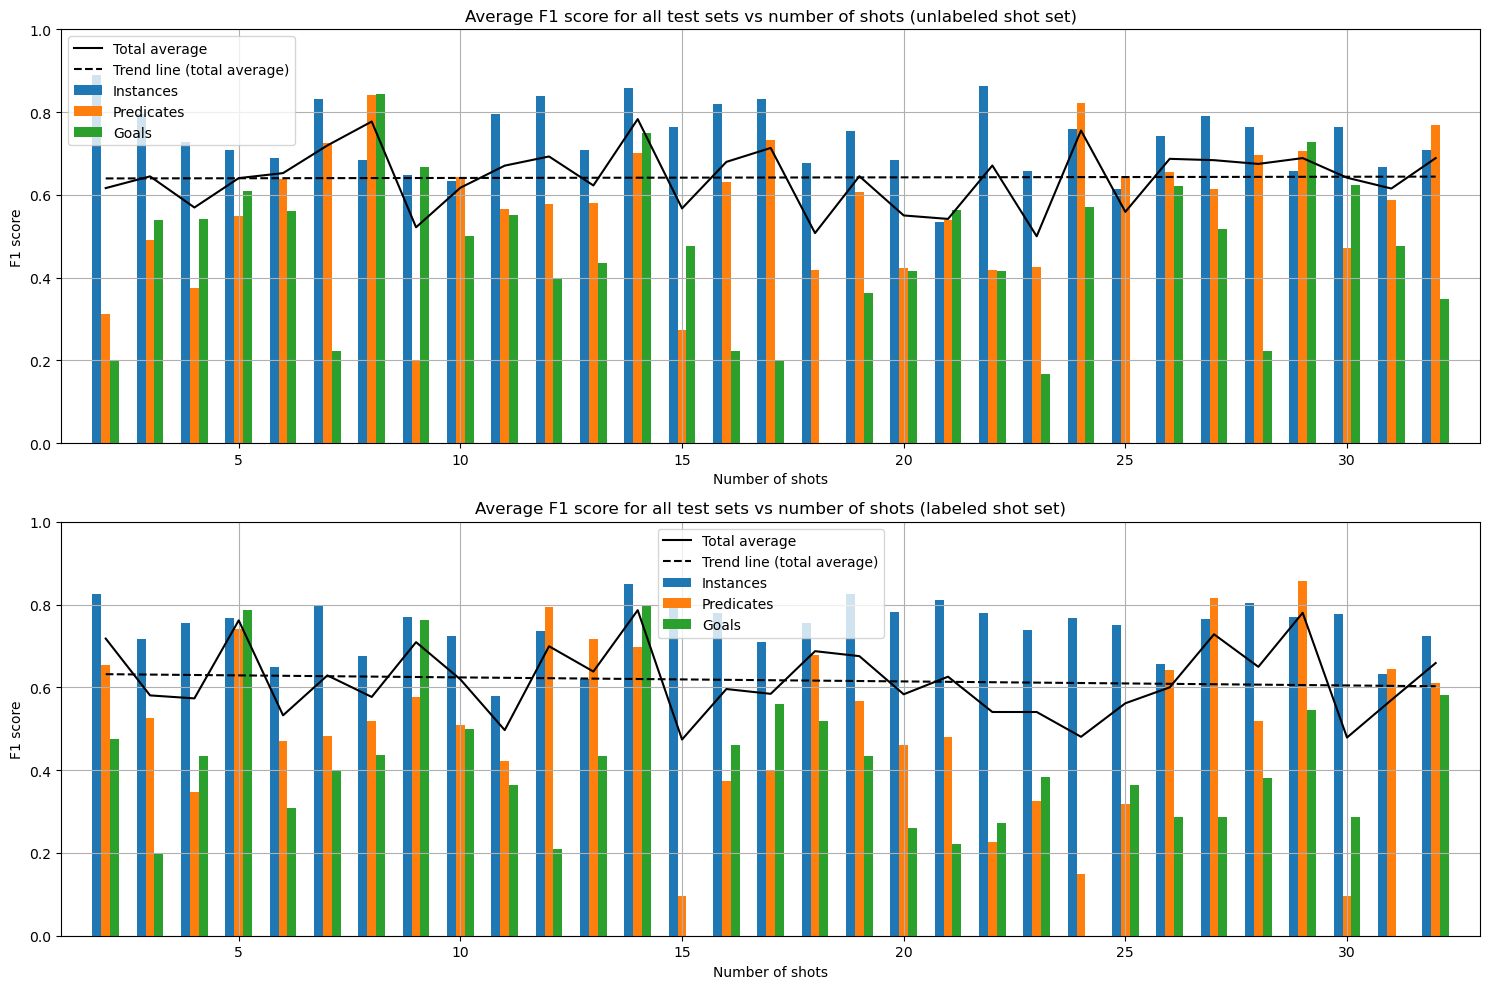

In [17]:
def f1_plot():
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))  # Create 2 subplots

    bar_width = 0.2
    bar_positions = np.arange(2, 33)

    # Plot unlabeled data
    axs[0].bar(bar_positions - bar_width, inst_f1_unlabeled, width=bar_width, label='Instances')
    axs[0].bar(bar_positions, pred_f1_unlabeled, width=bar_width, label='Predicates')
    axs[0].bar(bar_positions + bar_width, goal_f1_unlabeled, width=bar_width, label='Goals')
    axs[0].plot(bar_positions, total_f1_unlabeled, label='Total average', color='black')
    z = np.polyfit(bar_positions, total_f1_unlabeled, 1)
    p = np.poly1d(z)
    axs[0].plot(bar_positions, p(bar_positions), color="black", linestyle='--', label='Trend line (total average)')
    axs[0].set_xlabel('Number of shots')
    axs[0].set_ylabel('F1 score')
    axs[0].set_title('Average F1 score for all test sets vs number of shots (unlabeled shot set)')
    axs[0].legend()
    axs[0].grid()
    axs[0].set_ylim(0, 1)
    axs[0].set_xlim(1, 33)

    # Plot labeled data
    axs[1].bar(bar_positions - bar_width, inst_f1_labeled, width=bar_width, label='Instances')
    axs[1].bar(bar_positions, pred_f1_labeled, width=bar_width, label='Predicates')
    axs[1].bar(bar_positions + bar_width, goal_f1_labeled, width=bar_width, label='Goals')
    axs[1].plot(bar_positions, total_f1_labeled, label='Total average', color='black')
    z = np.polyfit(bar_positions, total_f1_labeled, 1)
    p = np.poly1d(z)
    axs[1].plot(bar_positions, p(bar_positions), color="black", linestyle='--', label='Trend line (total average)')
    axs[1].set_xlabel('Number of shots')
    axs[1].set_ylabel('F1 score')
    axs[1].set_title('Average F1 score for all test sets vs number of shots (labeled shot set)')
    axs[1].legend()
    axs[1].grid()
    axs[1].set_ylim(0, 1)
    axs[1].set_xlim(1, 33)

    plt.tight_layout()
    plt.savefig('f1.pdf', format='pdf')

f1_plot()

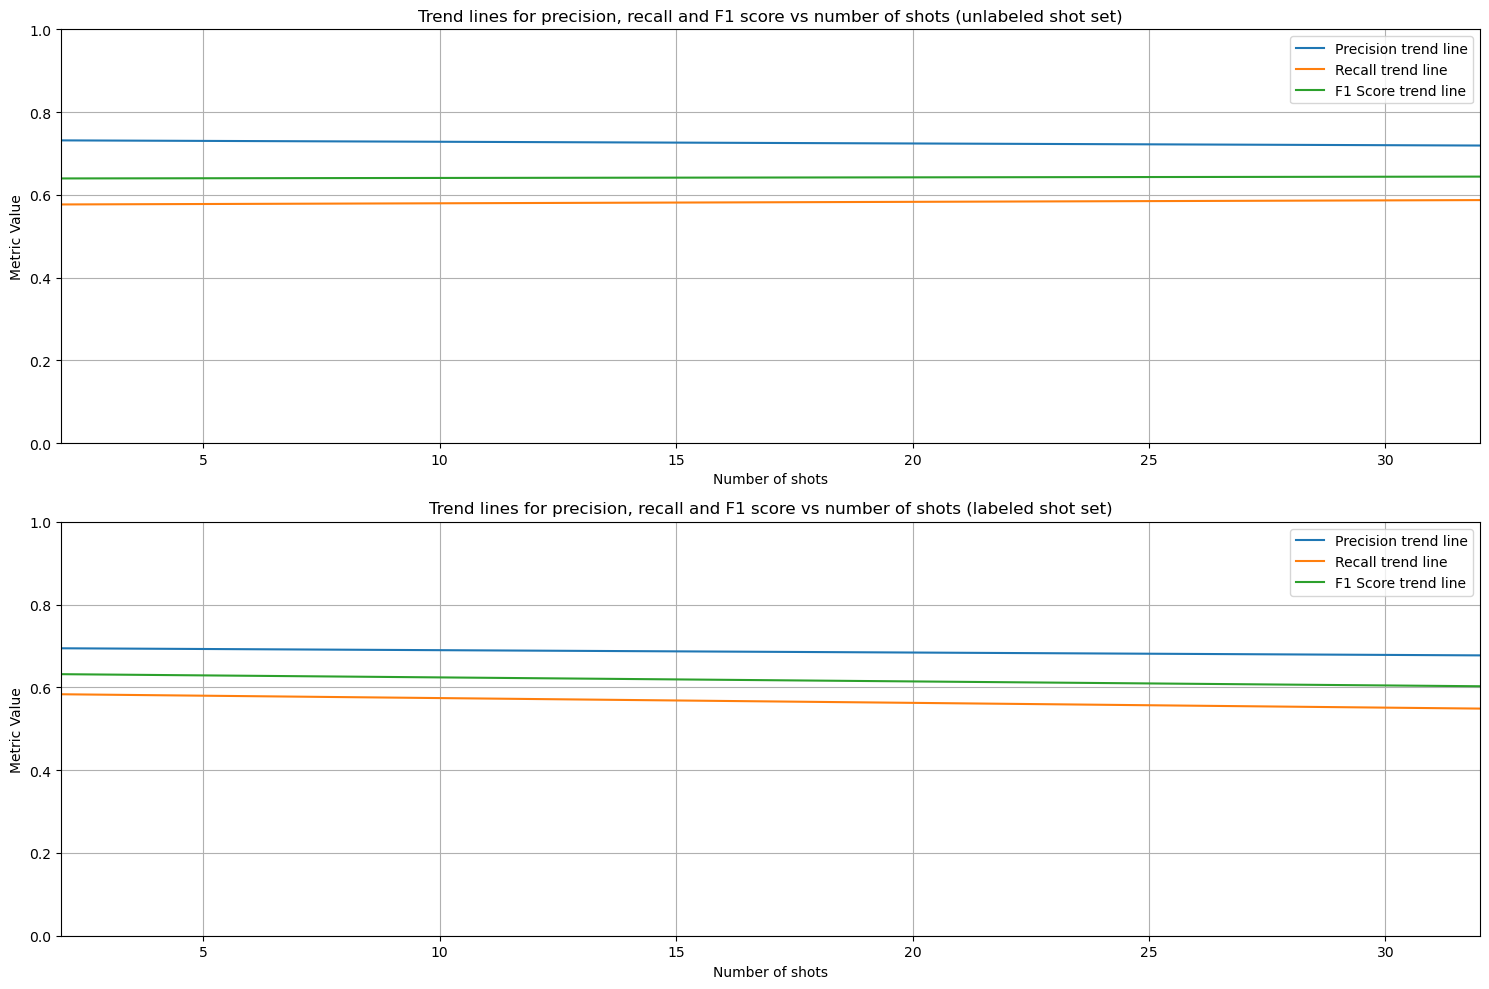

In [18]:
def trend_line_plot(precision_unlabeled, recall_unlabeled, f1_unlabeled, precision_labeled, recall_labeled, f1_labeled):
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))  # Create 2 subplots

    metrics_unlabeled = [precision_unlabeled, recall_unlabeled, f1_unlabeled]
    metrics_labeled = [precision_labeled, recall_labeled, f1_labeled]
    labels = ['Precision', 'Recall', 'F1 Score']

    for ax, metrics, title in zip(axs, [metrics_unlabeled, metrics_labeled], ['unlabeled', 'labeled']):
        for metric, label in zip(metrics, labels):
            # calculate and plot trend line
            z = np.polyfit(np.arange(2, 33), metric, 1)
            p = np.poly1d(z)
            ax.plot(np.arange(2, 33), p(np.arange(2, 33)), label=f'{label} trend line')

        ax.set_xlabel('Number of shots')
        ax.set_ylabel('Metric Value')
        ax.set_title(f'Trend lines for precision, recall and F1 score vs number of shots ({title} shot set)')
        ax.grid()
        ax.legend()

        ax.set_ylim(0, 1)
        ax.set_xlim(2, 32)

    plt.tight_layout()
    plt.savefig('trend_lines.pdf', format='pdf')
    plt.show()


trend_line_plot(total_precision_unlabeled, total_recall_unlabeled, total_f1_unlabeled, total_precision_labeled, total_recall_labeled, total_f1_labeled)

In [19]:
# instances, predicates and goals in each sublist respectively
unlabeled = [[
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
            0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 
            1,0, 0, 0, 1,1,1,0, 1, 1, 1, 1, 1, 0,  0,  1, 0,  0,  0,  0,  0,  0,  1, 1, 0,  1, 0,  0,  0,  0,  1,
            1,1,1,1,0, 0, 0, 1,1, 0,  0,  1, 1, 0,  1, 1, 1, 1, 0,  0,  0,  1, 1, 0,  1, 1, 1, 0,  1, 0,  1,
            1,0, 0, 1,0, 0, 0, 0, 0,  0,  1, 1, 1, 0,  0,  1, 0,  0,  0,  0,  1, 0,  0,  1, 1, 1, 1, 0,  0,  1, 1,
            0, 0, 0, 0, 0, 0, 1,0, 1, 0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 
            1,1,0, 1,0, 1,0, 0, 0,  0,  0,  0,  0,  1, 0,  1, 0,  0,  0,  1, 1, 1, 0,  0,  0,  1, 1, 0,  0,  1, 0, 
            1,1,0, 1,0, 0, 0, 1,0,  0,  1, 0,  1, 1, 0,  0,  0,  0,  1, 0,  1, 0,  0,  1, 0,  1, 1, 1, 1, 0,  0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  1, 0,  0, 
            ],
            [    
            0, 0, 0, 1,0, 0, 0, 0, 0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  1, 0, 
            0, 0, 1,0, 0, 0, 1,0, 1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  1, 1, 0,  0,  0,  0,  1, 1, 0,  0, 
            0, 0, 0, 0, 1,1,0, 0, 0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  1, 0,  1, 0,  0,  0,  0,  0,  0, 
            0, 0, 0, 0, 1,0, 1,0, 1, 0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0, 
            0, 0, 0, 1,0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 1, 0,  0,  0,  0,  0,  0,  0,  0, 
            1,1,1,0, 0, 0, 1,1,0,  1, 0,  0,  0,  1, 0,  0,  1, 0,  1, 1, 0,  1, 0,  0,  0,  0,  0,  1, 0,  1, 0, 
            0, 0, 0, 0, 0, 0, 1,0, 1, 0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 
            0, 0, 0, 1,0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0, 
            0, 0, 0, 0, 0, 0, 0, 1,0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  1, 0,  0, 
            ],
            [
            0, 0, 0, 1,0, 0, 0, 0, 0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  1, 0, 
            0, 0, 0, 0, 0, 0, 1,0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  1, 1, 0,  1, 1, 0,  0, 
            0, 0, 0, 0, 1,0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  1, 0,  0,  0,  0,  0,  0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0, 
            0, 0, 0, 1,0, 0, 1,0, 1, 0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  1, 1, 0,  0,  0,  0,  0,  0,  0,  0, 
            0, 1,1,0, 1,0, 1,0, 0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 1, 0, 
            0, 0, 0, 0, 0, 0, 1,1,1, 0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 
            0, 0, 0, 1,0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  1, 1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0, 
            0, 0, 0, 0, 0, 0, 0, 0, 0,  1, 0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  1, 0,  0, 
            ]]

labeled = [[
            0, 1,0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  1, 0,  1, 1, 0,  0,  0, 
            0, 0, 1,1,0, 0, 0, 1,0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0, 
            0, 0, 0, 0, 1,0, 0, 0, 1, 0,  0,  0,  1, 0,  0,  0,  0,  1, 0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  0, 
            1,0, 0, 1,0, 1,0, 0, 1, 0,  1, 1, 1, 0,  0,  0,  0,  0,  0,  1, 1, 1, 0,  0,  1, 1, 0,  0,  0,  0,  1,
            0, 1,1,1,1,0, 1,0, 1, 0,  0,  1, 1, 1, 0,  0,  1, 0,  0,  0,  1, 1, 1, 1, 1, 0,  1, 0,  1, 1, 0, 
            1,0, 1,0, 0, 1,0, 1,0,  0,  1, 0,  0,  1, 1, 1, 0,  0,  0,  0,  1, 0,  1, 1, 1, 1, 1, 0,  0,  0,  1,
            0, 0, 0, 0, 0, 0, 0, 1,0,  0,  0,  0,  1, 0,  0,  0,  1, 1, 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0, 
            1,0, 0, 1,0, 0, 0, 0, 0,  0,  1, 1, 0,  0,  1, 1, 1, 0,  0,  0,  0,  0,  1, 0,  0,  1, 0,  0,  0,  0,  1,
            0, 0, 0, 0, 1,0, 0, 1,1, 0,  0,  0,  1, 0,  0,  0,  0,  1, 1, 0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  1, 0, 
            0, 0, 0, 0, 0, 0, 1,0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0, 
            ],
            [
            0, 1,0, 0, 0, 0, 0, 0, 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 0,  0,  0,  0,  1, 0,  1, 1, 0, 0, 0,
            0,0,1,0,0,0,1,1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,0,0,0,0,0,0,0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,0,1,0,0,0,0,1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
            0,0,0,0,0,0,0,0,0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,1,1,1,0,0,0,0,0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
            0,0,0,0,0,0,0,0,0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,0,1,0,0,0,0,0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,0,0,0,0,0,0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,0,0,0,0,1,0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
            ],
            [
            0,1,0,0,0,0,0,0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
            0,0,0,0,0,0,0,1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,0,0,0,0,0,0,0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,0,1,0,0,0,0,1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
            0,0,0,0,0,0,0,1,0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,1,1,0,0,0,0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
            0,0,0,0,0,0,0,1,0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,0,1,0,0,0,0,0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0,0,0,1,1,0,0,0,0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
            0,0,0,0,0,0,1,0,0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
            ]]

total_unlabeled = [1 if all(sublist[i] == 1 for sublist in unlabeled) else 0 for i in range(len(unlabeled[0]))]
total_labeled = [1 if all(sublist[i] == 1 for sublist in labeled) else 0 for i in range(len(labeled[0]))]

unlabeled_arr = np.array(total_unlabeled)
unlabeled = unlabeled_arr.reshape(10, 31)

labeled_arr = np.array(total_labeled)
labeled = labeled_arr.reshape(10, 31)

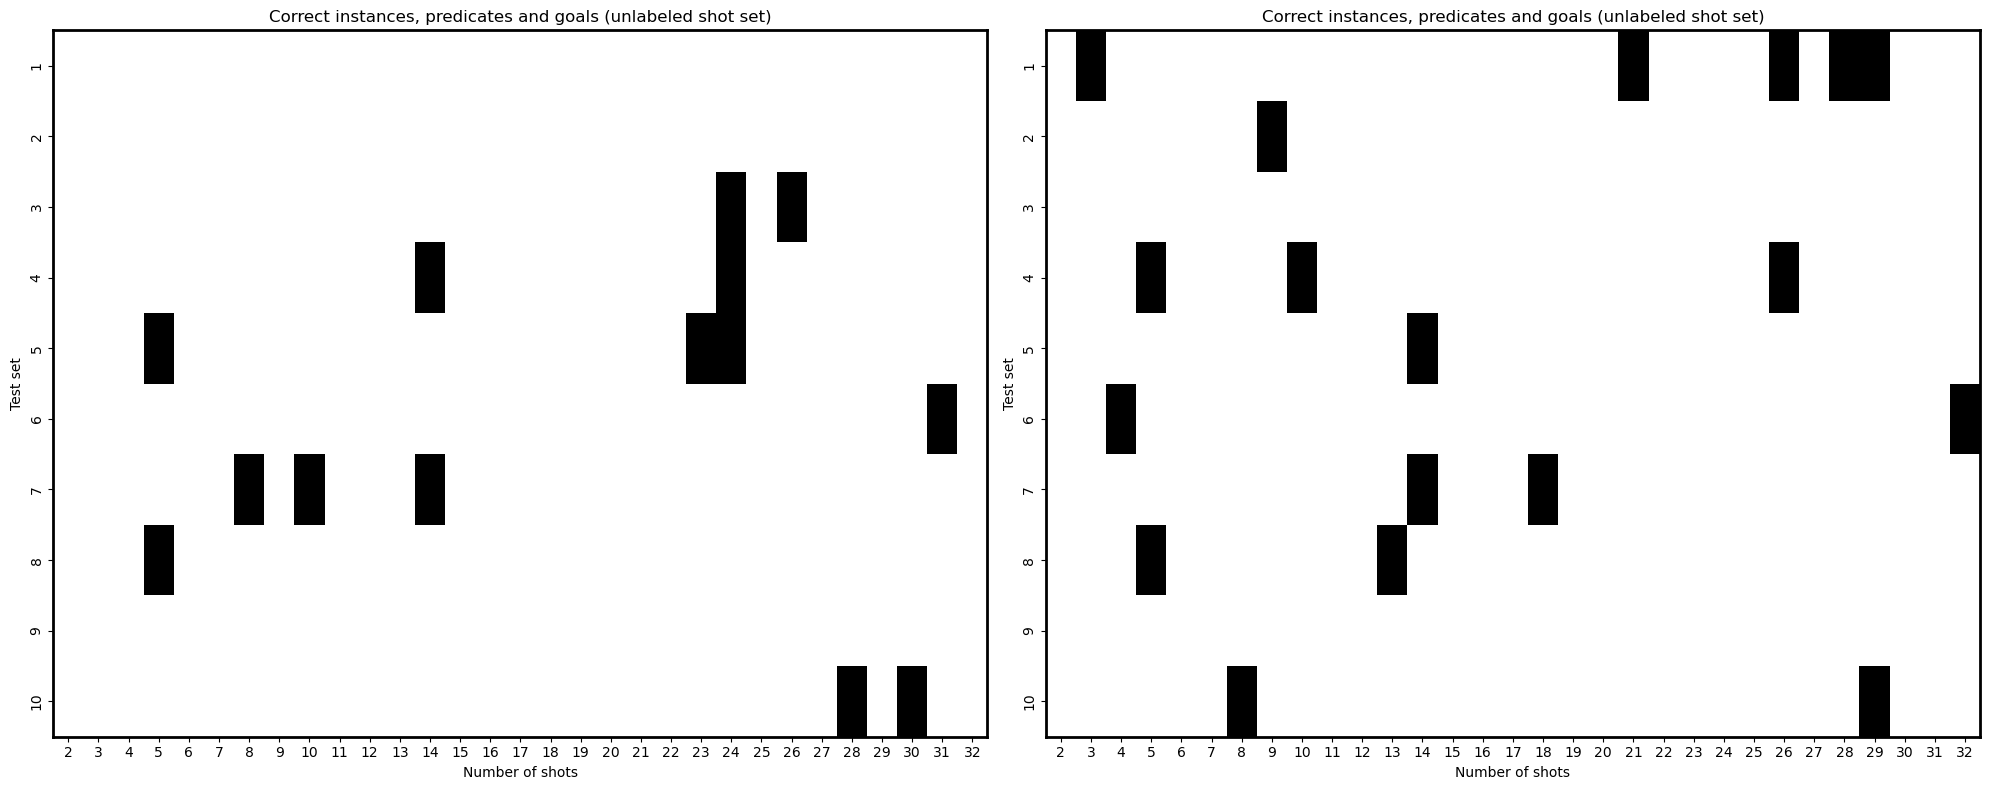

In [21]:
def plot_heatmaps(labeled, unlabeled):
    fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

    # Plot unlabeled heatmap
    ax1 = sns.heatmap(unlabeled, cmap='binary', ax=axs[0], cbar=False)
    ax1.set_yticklabels(range(1, 11))
    ax1.set_xticklabels(range(2, 33))
    ax1.set_title('Correct instances, predicates and goals (unlabeled shot set)')
    ax1.set_ylabel('Test set')
    ax1.set_xlabel('Number of shots')

    for _, spine in ax1.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)

    # Plot labeled heatmap
    ax2 = sns.heatmap(labeled, cmap='binary', ax=axs[1], cbar=False)
    ax2.set_yticklabels(range(1, 11))
    ax2.set_xticklabels(range(2, 33))
    ax2.set_title('Correct instances, predicates and goals (unlabeled shot set)')
    ax2.set_ylabel('Test set')
    ax2.set_xlabel('Number of shots')

    for _, spine in ax2.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)

    # fig.suptitle('Heatmaps of test sets with all correct predictions')

    plt.tight_layout()
    plt.show()

    # save to pdf
    fig.savefig('heatmaps.pdf')

plot_heatmaps(labeled, unlabeled)